In [1]:
from typing import Tuple
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize, minimize_scalar
import scipy
import matplotlib.pyplot as plt
from scipy.special import expit

### General Tools

In [2]:
def classification_accuracy(labels: np.array, X: np.array, theta: np.array) -> np.array:
    """

    :param labels: data labels in {-1, 1}.
    :param X: data matrix with features as columns.
    :param theta:
    :return:
    """
    labels_hat = sigma(X @ theta)
    # print(labels_hat)
    labels_hat = (labels_hat >= 0.5).astype(np.float32)
    labels_hat = 2*labels_hat - 1  # convert to {-1, 1}
    # print(labels)
    # print(labels_hat)

    diff = labels_hat - labels
    num_different = np.count_nonzero(diff)

    return (len(labels) - num_different) / len(labels)

### Generate Synthetic Data

In [3]:
def sigma(x):
    # return 1/(1+np.exp(-x))
    return expit(x)

In [4]:
d = 25  # dimension of feature space
N = 100  # number of data points
X = (2 * (np.random.rand(N, d + 1) - 0.5)).astype(np.float32)  # data matrix (features are columns) randomly generated with uniform distribution [-1, 1]
X[:, -1] = 1

# for i in range(d):
#     X[:, i] = (X[:, i] - np.average(X[:, i])) / np.std(X[:, i]) # normalize across features

weights = np.random.rand(d + 1)
weights /= np.linalg.norm(weights)  # normalize weights

y = 2 * (sigma(X @ weights.T) > 0.5) - 1  # generate labels in {-1, 1}
y = y.astype(np.float32)

classification_accuracy(y, X, weights)

1.0

In [5]:
X

array([[ 0.7857542 ,  0.57387674, -0.9954578 , ..., -0.13757947,
        -0.28806257,  1.        ],
       [-0.09194954,  0.99901   , -0.4332709 , ..., -0.99859583,
         0.5618968 ,  1.        ],
       [ 0.927574  , -0.6871207 ,  0.3431673 , ...,  0.54042584,
         0.78090006,  1.        ],
       ...,
       [-0.97153085, -0.43217507, -0.23902155, ...,  0.14274243,
         0.19929558,  1.        ],
       [ 0.65040565,  0.10609035,  0.5549568 , ...,  0.41713485,
        -0.133678  ,  1.        ],
       [ 0.534135  , -0.18072961, -0.9692842 , ..., -0.9079053 ,
         0.16191132,  1.        ]], dtype=float32)

Lipschitz constants

In [6]:
max_sigma = scipy.linalg.svdvals(X)[0]

In [7]:
L1 = (1 / (4 * N)) * max_sigma * max_sigma

In [8]:
L2 = 1 / (6 * np.sqrt(3)) * (1 / N) * np.max(np.linalg.norm(X, axis=0)) * max_sigma  # TODO: Verify

In [9]:
print(f"L1={L1}, L2={L2}")

L1=0.2685403498523465, L2=0.09972932810071589


### Problem Definition

In [476]:
def log1pexp(x: np.array):
    result = np.zeros((len(x),), dtype=np.float32)
    for i in range(len(x)):
        if x[i] <= -37:
            result[i] = np.exp(x[i])
        elif x[i] <= 18:
            result[i] = np.log1p(np.exp(x[i]))
        elif x[i] < 33.3:
            result[i] = x[i] + np.exp(-x[i])
        else:
            result[i] = x[i]
    return result

In [477]:
log1pexp(np.array([1, 2, 3]))

array([1.3132616, 2.126928 , 3.0485873], dtype=float32)

In [478]:
np.log1p(np.exp(np.array([1, 2, 3])))

array([1.31326169, 2.12692801, 3.04858735])

In [548]:
np.exp(-y*(X@theta))

/tmp/ipykernel_197/1342251788.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(-y*(X@theta))


array([ 0.,  0., inf,  0., inf, inf, inf, inf, inf,  0.,  0.,  0.,  0.,
       inf, inf,  0.,  0.,  0.,  0.,  0.,  0., inf,  0., inf,  0.,  0.,
        0., inf,  0.,  0., inf,  0.,  0., inf,  0.,  0., inf,  0.,  0.,
        0., inf,  0.,  0., inf,  0., inf, inf,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., inf,  0.,  0.,  0.,  0., inf, inf,
        0., inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., inf,
       inf,  0., inf,  0., inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [550]:
def f(theta: np.array) -> float:
    # return (1/N) * np.sum(log1pexp(-y*(X@theta)))
    return np.sum(np.log(1 + np.exp(-y*(X@theta)))) / N

In [549]:
def f_grad(theta: np.array) -> np.array:
    # z = -y * expit(y*(X@theta))
    # gradient = X.T @ z / N
    z = -y / (1 + np.exp(y*(X@theta)))
    gradient = X.T @ z / N
    return gradient

In [551]:
def f_hessian(theta: np.array) -> np.array:
    H = np.zeros((len(theta), len(theta)))

    sigma_xw = sigma(X @ theta)
    sigma_lookup = sigma_xw * (1 - sigma_xw)

    for j in range(len(theta)):
        for k in range(j, len(theta)):
            H[j, k] = np.sum(X[:, j] * X[:, k] * sigma_lookup)
            H[k, j] = H[j, k]
            
    return H

In [642]:
def f_third_order(theta: np.array, h: np.array) -> np.array:
#     one_over_one_plus_exp = 1 / (1 + np.exp(y*(X@theta)))
#     third_order_array = (y * np.square(one_over_one_plus_exp)) * (2*np.exp(-2*y*(X@theta)) * one_over_one_plus_exp - np.exp(-y*(X@theta)))
#     third_order_array = X.T @ (third_order_array * np.square(np.dot(y @ X, h)))
#     third_order_array /= N
    third_order_array = np.zeros((len(theta),), dtype=np.float32)
    
    for i in range(N):
        beta_i = np.exp(-y[i]*np.dot(X[i, :], theta))
        ai = y[i]*X[i, :]
        third_order_array -= ai * np.dot(ai, h)**2 * (1/((1+beta_i)**2)) * (2*beta_i**2 / (1+beta_i) - beta_i)
    
    return third_order_array

### Optimization with Newton's Method

In [643]:
num_iters = 1000

In [644]:
alpha = 0.01

In [645]:
loss_newton = np.ones((num_iters,), dtype=np.float32)

In [646]:
grad_norms_newton = np.ones((num_iters,), dtype=np.float32)

In [647]:
start_theta = np.random.rand(d+1)

In [648]:
theta = np.copy(start_theta)

In [649]:
for k in tqdm(range(num_iters)):
    # Get local information
    loss_newton[k] = f(theta)
    grad = f_grad(theta)
    grad_norms_newton[k] = np.linalg.norm(grad)
    H = f_hessian(theta)
    
    h = -np.linalg.inv(H) @ grad
    # print(h)
        
    theta += h

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 567.47it/s]


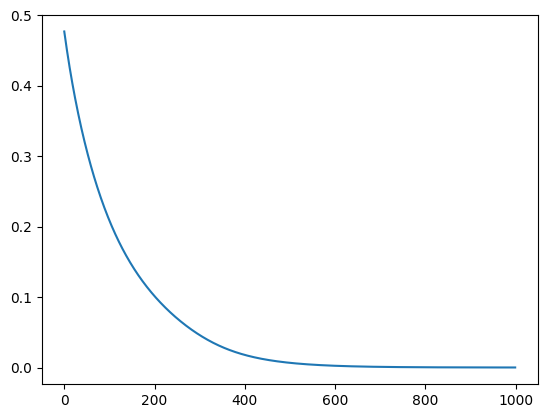

In [650]:
plt.plot(loss_newton)

In [651]:
theta_newton = np.copy(theta)

In [652]:
theta_newton

array([16.95408075, 20.49380794,  3.62026943,  8.11117184,  9.40104024,
        9.45356453,  9.18932654,  6.13295524, 12.15960526, 20.32663685,
        6.88222986,  5.91879824, 17.6076839 ,  5.61882502, 19.63369455,
        7.85686819, 13.33871487, 11.61376366,  4.46382562,  8.80255235,
       21.28345323,  8.58418805, 15.29601024, -2.30737385,  4.32439293,
       22.27075003])

In [653]:
classification_accuracy(y, X, theta)

1.0

### Optimization Method without Auxiliary Dual

In [759]:
num_iters = 1000

In [772]:
tau = 10

In [773]:
def bregman_d4(h, hk):
    return 0.25*(np.linalg.norm(h)**4 - np.linalg.norm(hk)**4) * np.dot(np.power(hk, 3), h - hk)

In [774]:
h1 = np.ones((5, ))
h2 = np.random.rand(5)

print(bregman_d4(h1, h2))

0.8730897005424096


In [784]:
L3 = 100 # TODO: change thiS

In [798]:
def auxiliary_problem(h: np.array, *args) -> float:
    hk, omega_grad, H = args
    
    p1 = np.dot(omega_grad, h - hk)
    p2 = (1/tau)*np.dot(H@(h-hk), h-hk)
    p3 = tau*L3*bregman_d4(h, hk)
    # print(f"p1: {p1}, p2: {p2}, p3: {p3}")
    
    return p1 + 0.5*(tau+1)*(p2 + p3)

In [799]:
loss = np.ones((num_iters,), dtype=np.float32)

In [800]:
grad_norms = np.ones((num_iters,), dtype=np.float32)

In [801]:
theta = np.copy(start_theta)

In [802]:
f(theta)

0.4770548708033157

In [803]:
for k in tqdm(range(num_iters)):
    # Get local information
    loss[k] = f(theta)
    grad = f_grad(theta)
    grad_norms[k] = np.linalg.norm(grad)
    H = f_hessian(theta)
    
    h = np.zeros((d+1,), dtype=np.float32)
    
    for _ in range(1000):
        c = grad + H@h + f_third_order(theta, h)
        h = minimize(auxiliary_problem, h, args=(h, c, H)).x
        
    # print(h)
        
    theta += h

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:09<00:00,  1.03it/s]


In [804]:
loss

array([4.77054864e-01, 4.72391725e-01, 4.67807472e-01, 4.63299662e-01,
       4.58865911e-01, 4.54503745e-01, 4.50211078e-01, 4.45985943e-01,
       4.41826344e-01, 4.37730312e-01, 4.33696091e-01, 4.29721862e-01,
       4.25805926e-01, 4.21946704e-01, 4.18142557e-01, 4.14392292e-01,
       4.10694063e-01, 4.07046795e-01, 4.03449029e-01, 3.99899483e-01,
       3.96396905e-01, 3.92940164e-01, 3.89528096e-01, 3.86159599e-01,
       3.82833689e-01, 3.79549295e-01, 3.76305461e-01, 3.73101264e-01,
       3.69935811e-01, 3.66808236e-01, 3.63717705e-01, 3.60663384e-01,
       3.57644528e-01, 3.54660392e-01, 3.51710260e-01, 3.48793417e-01,
       3.45909208e-01, 3.43056977e-01, 3.40236127e-01, 3.37446034e-01,
       3.34686130e-01, 3.31955850e-01, 3.29254687e-01, 3.26582104e-01,
       3.23937595e-01, 3.21320653e-01, 3.18730861e-01, 3.16167742e-01,
       3.13630819e-01, 3.11119735e-01, 3.08634043e-01, 3.06173325e-01,
       3.03737223e-01, 3.01325381e-01, 2.98937410e-01, 2.96572953e-01,
      

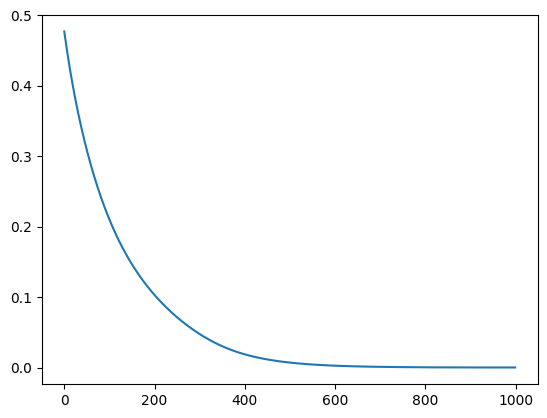

In [805]:
plt.plot(loss)

In [806]:
theta_hyperfast = np.copy(theta)

In [807]:
classification_accuracy(y, X, theta)

1.0

### Optimization Method with Auxiliary Dual

In [753]:
loss_dual = np.ones((num_iters,), dtype=np.float32)

In [638]:
grad_norms_dual = np.ones((num_iters,), dtype=np.float32)

In [639]:
theta = np.copy(start_theta)

In [640]:
def dual_auxiliary(tau: float, *args) -> float:
    gamma, T, c_tilda = args
    inv_part = np.linalg.lstsq(gamma*tau*np.eye(T.shape[0]), c_tilda, rcond=None)[0]
    return -0.5*tau*tau + 0.5*np.dot(inv_part, c_tilda)

In [720]:
for k in tqdm(range(num_iters)):
    # Get local information
    loss_dual[k] = f(theta)
    grad = f_grad(theta)
    grad_norms_dual[k] = np.linalg.norm(grad)
    H = f_hessian(theta)
        
    h = np.zeros((d+1,), dtype=np.float32)
    for _ in range(10):
        c = grad + H@h + f_third_order(theta, h)
        Lambda, U = np.linalg.eig(H)
#         print("Lambda:")
#         print(Lambda)
#         print("U:")
#         print(U)
        c_tilda = U.T @ c
        
        best_tau = minimize_scalar(dual_auxiliary, bounds=[0, 100], args=(gamma, Lambda, c_tilda), options={'disp': False}).x
        print(best_tau)
        h = np.linalg.lstsq((gamma*best_tau*np.eye(Lambda.shape[0]) + Lambda)@U.T, -c_tilda, rcond=None)[0]
        
    theta += h

### Comparison

In [808]:
print(np.linalg.norm(theta_newton - theta_hyperfast))

11.665396795314301


In [809]:
theta_newton

array([16.95408075, 20.49380794,  3.62026943,  8.11117184,  9.40104024,
        9.45356453,  9.18932654,  6.13295524, 12.15960526, 20.32663685,
        6.88222986,  5.91879824, 17.6076839 ,  5.61882502, 19.63369455,
        7.85686819, 13.33871487, 11.61376366,  4.46382562,  8.80255235,
       21.28345323,  8.58418805, 15.29601024, -2.30737385,  4.32439293,
       22.27075003])

In [810]:
theta_hyperfast

array([13.22327131, 17.51644506,  3.16277694,  6.53742599,  7.20662546,
        8.31409093,  7.16556605,  4.51879927, 10.39058555, 16.86719176,
        6.12952358,  4.73101407, 14.23914333,  5.3836945 , 15.65304985,
        7.06778759, 11.91471109,  9.8502661 ,  4.56895228,  5.9589487 ,
       17.68003263,  6.10048002, 13.3874346 , -1.01731385,  3.95331025,
       18.39532916])

Text(0, 0.5, 'Loss')

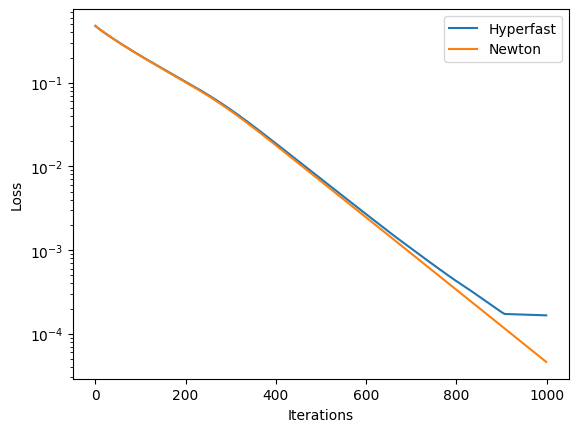

In [811]:
plt.semilogy(loss, label="Hyperfast")
plt.semilogy(loss_newton, label="Newton")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")

Text(0, 0.5, 'Gradient Norm')

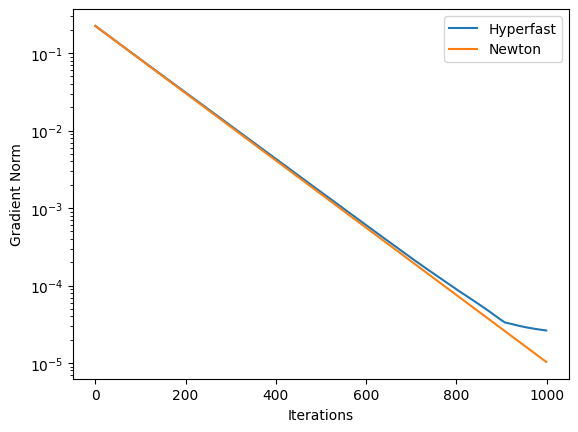

In [812]:
plt.semilogy(grad_norms, label="Hyperfast")
plt.semilogy(grad_norms_newton, label="Newton")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Gradient Norm")

In [10]:
cpu_times = [0.111546755, 0.074084759, 22.17986989, 39.4575727, 50.16345143, 82.01188707]

In [11]:
gpu_times = [0.091855764, 0.07700634, 2.608466148, 6.264713049, 5.868836164, 6.776931047]

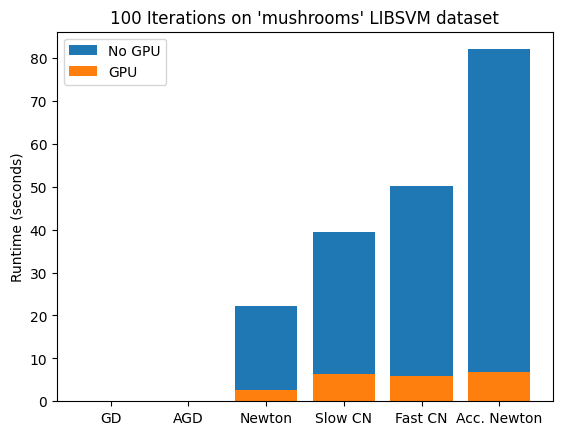

In [12]:
plt.bar(['GD', 'AGD', 'Newton', 'Slow CN', 'Fast CN', 'Acc. Newton'], cpu_times, label="No GPU")
plt.bar(['GD', 'AGD', 'Newton', 'Slow CN', 'Fast CN', 'Acc. Newton'], gpu_times, label="GPU")
plt.ylabel("Runtime (seconds)")
plt.title("100 Iterations on 'mushrooms' LIBSVM dataset")
plt.legend()

In [15]:
np.array(cpu_times) / np.array(gpu_times)

array([ 1.21436859,  0.96206051,  8.50303153,  6.29838468,  8.54742747,
       12.10162631])